In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Circle

from matplotlib.ticker import MultipleLocator
import seaborn as sns

#plt.style.use('science')

import os
os.chdir("".join((os.getcwd().split("PCNN")[0], "/PCNN/src/")))
import utils as utc
import core.build.pclib as pclib
from game.envs import *
from game.constants import *
import game.objects as objects

import simulations as sim

#import pcnn_core as pcr
from IPython.display import clear_output
from tqdm import tqdm
import time, json

%load_ext autoreload
%autoreload 2

#plt.style.use('classic')

logger = utc.setup_logger("M", level=1)
logger()

2025-02-27 20:12:29 | 


pygame 2.5.2 (SDL 2.28.3, Python 3.11.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


**General**

In [2]:
MPATH = "../media/plots"

**Figure styles**

In [3]:
#plt.style.use('science')  # Requires matplotlib-style package
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times', 'Computer Modern Roman'],
    'text.usetex': True,
    'axes.labelsize': 10,
    'font.size': 10,
    'legend.fontsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8
})

#### Parameters

In [4]:
reward_settings = {
    "rw_fetching": "probabilistic",
    "rw_value": "discrete",
    "rw_position": np.array([0.5, 0.3]) * GAME_SCALE,
    "rw_radius": 0.1 * GAME_SCALE,
    "rw_sigma": 0.7,# * GAME_SCALE,
    "rw_bounds": np.array([0.23, 0.77,
                           0.23, 0.77]) * GAME_SCALE,
    "delay": 5,
    "silent_duration": 2_000,
    "fetching_duration": 3,
    "transparent": False,
    "beta": 40.,
    "alpha": 0.06,# * GAME_SCALE,
    "tau": 300,# * GAME_SCALE,
    "move_threshold": 6,# * GAME_SCALE,
}

game_settings = {
    "plot_interval": 5,
    "rw_event": "move both",
    "rendering": False,
    "rendering_pcnn": False,
    "agent_bounds": np.array([0.23, 0.77,
                              0.23, 0.77]) * GAME_SCALE,
    "max_duration": 10_000,
    "room_thickness": 20,
    "t_teleport": 100,
    "seed": None,
    "pause": -1,
    "verbose": True
}

global_parameters = {
    "local_scale_fine": 0.02,
    "local_scale_coarse": 0.006,
    "N": 25**2,
    "Nc": 16**2,
    "use_sprites": False,
    "speed": 1.,
    "min_weight_value": 0.5
}

parameters = {

    "gain_fine": 15.,
    "offset_fine": 1.0,
    "threshold_fine": 0.3,
    "rep_threshold_fine": 0.9,
    "rec_threshold_fine": 45.,
    "tau_trace_fine": 30.0,

    "remap_tag_frequency": 1,
    "num_neighbors": 8,
    "min_rep_threshold": 34,

    "gain_coarse": 21.,
    "offset_coarse": 1.1,
    "threshold_coarse": 0.3,
    "rep_threshold_coarse": 0.6,
    "rec_threshold_coarse": 50.,
    "tau_trace_coarse": 50.0,

    "lr_da": 0.5,
    "lr_pred": 0.2,
    "threshold_da": 0.03,
    "tau_v_da": 20.0,

    "lr_bnd": 0.6,
    "threshold_bnd": 0.3,
    "tau_v_bnd": 3.0,

    "tau_ssry": 100.,
    "threshold_ssry": 0.995,

    "threshold_circuit": 0.9,
    "remapping_flag": 7,

    "rwd_weight": 15.0,
    "rwd_sigma": 80.0,
    "col_weight": 0.0,
    "col_sigma": 35.0,

    "rwd_field_mod_fine": 2.5,
    "rwd_field_mod_coarse": 4.5,
    "col_field_mod_fine": 1.5,
    "col_field_mod_coarse": 0.3,

    "action_delay": 80.,
    "edge_route_interval": 50000, # <<<<<<<<<<<<<<<<<<<

    "forced_duration": 100,
    "fine_tuning_min_duration": 10,

}

logger()

2025-02-27 20:12:29 | 


## other

In [18]:
_ = space([-p[0] + points[-1][0], -p[1] + points[-1][1]])

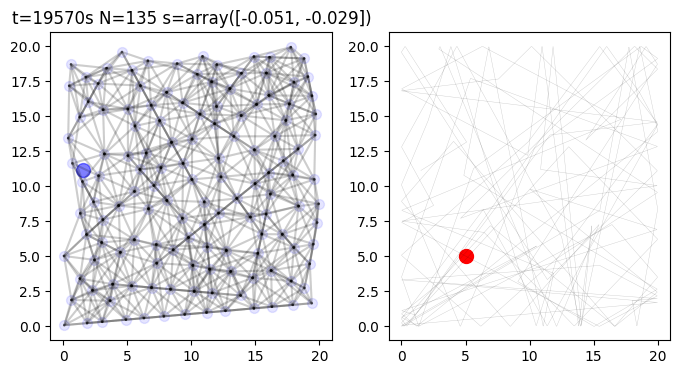

In [3]:
p = [5, 5]

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.scatter(*np.array(space.get_position()).T, s=100, color="blue", alpha=0.5)
plt.scatter(*np.array(space.get_centers()).T, s=50, color="blue", alpha=0.1)
#plt.scatter(*p, s=100, c='r')
for edge in space.make_edges():
    plt.plot((edge[0][0], edge[1][0]), (edge[0][1], edge[1][1]),
                                  alpha=0.1, color="black")


plt.xlim((-1, size+1))
plt.ylim((-1, size+1))
plt.title(f"t={t}s N={len(space)} {s=}")

plt.subplot(122)
plt.plot(*np.array(points).T, 'k-', lw=0.3, alpha=0.2)
plt.scatter(*p, s=100, c='r')
plt.xlim((-1, size+1))
plt.ylim((-1, size+1))
plt.show()

In [4]:
conn = space.get_connectivity()

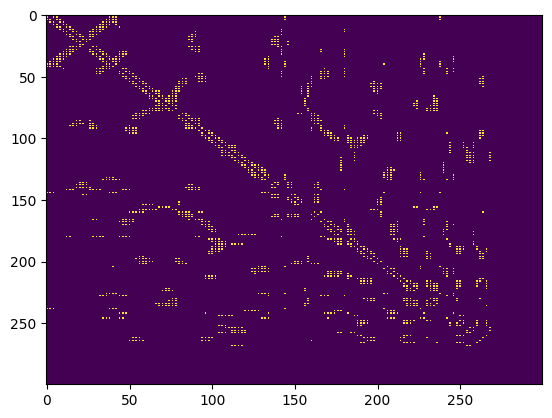

In [17]:
plt.imshow(conn, interpolation="nearest", aspect="auto");

In [12]:
conn[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

## GC plot

In [180]:
N = 300

gc = pclib.GridLayerSq(sigma=0.01, speed=0.5, bounds=[-1, 1, -1, 1])

# random walk
speed = 0.08
size = 10.

points = [[0., 0.]]

s = np.array([speed, speed])
x, y = points[0]
old_point = points[0]

tot = 100_000

# record
activity = np.zeros((len(gc), tot))
plotting = False

for t in tqdm(range(tot)):
    
    x += s[0]
    y += s[1]

    # hit wall
    if x <= 0 or x >= size:
        s[0] *= -1
        x += s[0]
    elif y <= 0 or y >= size:
        s[1] *= -1
        y += s[1]

    points += [[x, y]]
    if t % 500 == 0:
        s = np.random.uniform(-1, 1, 2)
        s = speed * s / np.abs(s).sum()
        s = np.around(s, 3)

    activity[:, t] = gc([points[-1][0]-old_point[0],
                         points[-1][1]-old_point[1]])
    
    old_point = points[-1]

    if t % 100 == 0 and plotting:
        clear_output(wait=True)
        plt.figure(figsize=(4, 4))
        #plt.subplot(121)
        plt.plot(*np.array(points).T, 'k-', lw=0.3, alpha=0.3)
        
        #plt.scatter(*np.array(gc.get_positions()).T, s=50, color="blue")

        plt.title(f"{t=}")
        #plt.subplot(122)
        #plt.imshow(activity[:, t-500:t], cmap="plasma", aspect="auto")
        #plt.plot(range(len(activity)), len(activity) - activity*10, '-', color="white", lw=2)
        #plt.axis('off')
        
        plt.scatter(*points[-1], s=100, c='r')

        plt.xlim((-4, size+4))
        plt.ylim((-4, size+4))
        plt.pause(0.001)

logger()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:00<00:00, 331583.62it/s]
2025-02-18 17:15:59 | 


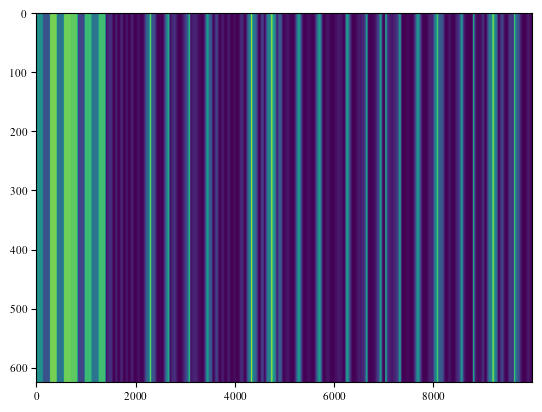

In [92]:
brain.get

In [54]:
colrs = plt.cm.rainbow(len(activity))

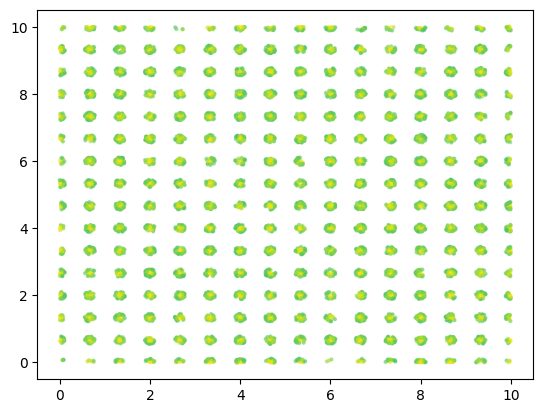

In [155]:
asum = activity[:, :].mean(axis=0)
plt.scatter(*np.array(points[1:]).T, c=asum, s=np.where(asum>0.02, 4, 0), alpha=0.5);


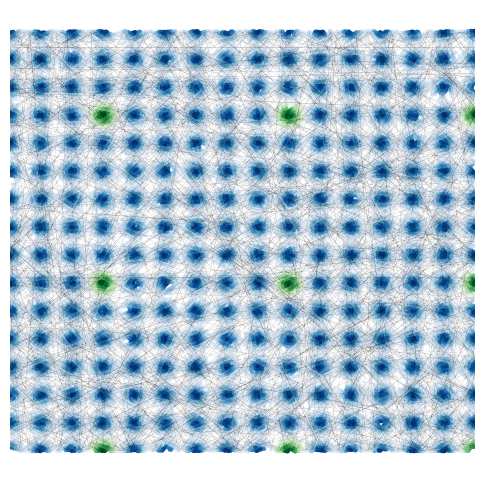

In [182]:
fig = plt.figure(figsize=(6, 6))
plt.plot(*np.array(points[1:]).T, "k-", lw=0.1, alpha=0.5)
plt.scatter(*np.array(points[1:]).T, c=activity[:, :].sum(axis=0), 
            s=np.where(activity[:, :].sum(axis=0)>0.1, 5, 0),
            alpha=0.9, cmap="Blues")
plt.scatter(*np.array(points[1:]).T, c=activity[3, :], 
            s=np.where(activity[3, :]>0.1, 5, 0),
            alpha=0.9, cmap="Greens")

plt.axis("off")
plt.xlim((0, size))
plt.xlim((0, size))

#plt.title("Grid cell layer")

plt.show()

### hex

In [19]:

gc = pclib.GridLayerHex(sigma=0.04, speed=0.6)

# random walk
speed = 0.08
size = 20.

points = [[0., 0.]]

s = np.array([speed, speed])
x, y = points[0]
old_point = points[0]

tot = 200_000

# record
activity = np.zeros((len(gc), tot))
plotting = False

for t in tqdm(range(tot)):
    
    x += s[0]
    y += s[1]

    # hit wall
    if x <= 0 or x >= size:
        s[0] *= -1
        x += s[0]
    elif y <= 0 or y >= size:
        s[1] *= -1
        y += s[1]

    points += [[x, y]]
    if t % 500 == 0:
        s = np.random.uniform(-1, 1, 2)
        s = speed * s / np.abs(s).sum()
        s = np.around(s, 3)

    activity[:, t] = gc([points[-1][0]-old_point[0],
                         points[-1][1]-old_point[1]])
    
    old_point = points[-1]

    if t % 100 == 0 and plotting:
        clear_output(wait=True)
        plt.figure(figsize=(4, 4))
        #plt.subplot(121)
        plt.plot(*np.array(points).T, 'k-', lw=0.3, alpha=0.3)
        
        #plt.scatter(*np.array(gc.get_positions()).T, s=50, color="blue")

        plt.title(f"{t=}")
        #plt.subplot(122)
        #plt.imshow(activity[:, t-500:t], cmap="plasma", aspect="auto")
        #plt.plot(range(len(activity)), len(activity) - activity*10, '-', color="white", lw=2)
        #plt.axis('off')
        
        plt.scatter(*points[-1], s=100, c='r')

        plt.xlim((-4, size+4))
        plt.ylim((-4, size+4))
        plt.pause(0.001)

logger()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200000/200000 [00:00<00:00, 394556.01it/s]
2025-02-17 20:55:41 | 


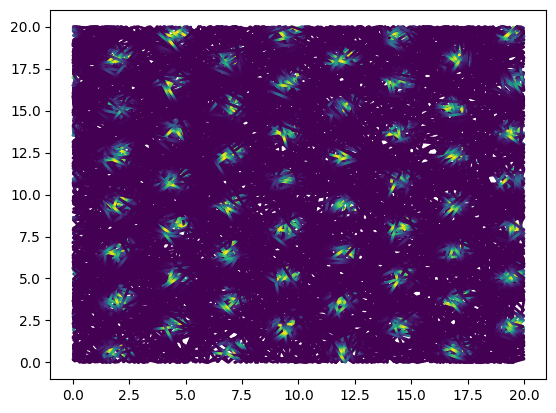

In [28]:
#asum = activity[:, :].mean(axis=0)
plt.scatter(*np.array(points[1:]).T, c=activity[0], s=1, alpha=1.)
plt.show()


### pcnn

100%|███████████████████████████████████████████████| 100000/100000 [13:39<00:00, 122.03it/s]
2025-02-18 03:47:11 | 


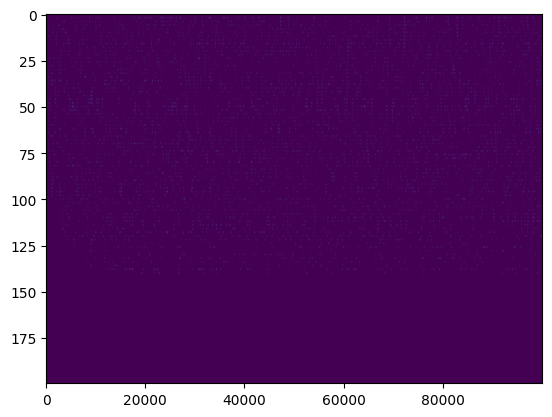

In [165]:
N = 200

local_scale = 0.02
gcn = pclib.GridNetworkSq([
            pclib.GridLayerSq(sigma=0.04, speed=1.*local_scale),
            pclib.GridLayerSq(sigma=0.04, speed=0.8*local_scale),
            pclib.GridLayerSq(sigma=0.04, speed=0.7*local_scale),
            pclib.GridLayerSq(sigma=0.04, speed=0.5*local_scale),
            pclib.GridLayerSq(sigma=0.04, speed=0.3*local_scale),
            pclib.GridLayerSq(sigma=0.04, speed=0.2*local_scale),
            pclib.GridLayerSq(sigma=0.04, speed=0.1*local_scale)])

pcnn = pclib.PCNN(N=N,
                  Nj=len(gcn),
                  gain=10.0,
                  offset=1.1,
                  clip_min=0.01,
                  threshold=0.3,
                  rep_threshold=0.9,
                  rec_threshold=1.0,
                  min_rep_threshold=0.99,
                  xfilter=gcn,
                  tau_trace=2.0,
                  name="2D")

brain = pclib.Brain(
            local_scale_fine=global_parameters["local_scale_fine"],
            local_scale_coarse=global_parameters["local_scale_coarse"],
            N=N,
            Nc=global_parameters["Nc"],
            min_rep_threshold=parameters["min_rep_threshold"],
            rec_threshold_fine=parameters["rec_threshold_fine"],
            rec_threshold_coarse=parameters["rec_threshold_coarse"],
            speed=global_parameters["speed"],
            gain_fine=parameters["gain_fine"],
            offset_fine=parameters["offset_fine"],
            threshold_fine=parameters["threshold_fine"],
            rep_threshold_fine=parameters["rep_threshold_fine"],
            tau_trace_fine=parameters["tau_trace_fine"],
            gain_coarse=parameters["gain_coarse"],
            offset_coarse=parameters["offset_coarse"],
            threshold_coarse=parameters["threshold_coarse"],
            rep_threshold_coarse=parameters["rep_threshold_coarse"],
            tau_trace_coarse=parameters["tau_trace_coarse"],
            lr_da=parameters["lr_da"],
            threshold_da=parameters["threshold_da"],
            tau_v_da=parameters["tau_v_da"],
            lr_bnd=parameters["lr_bnd"],
            threshold_bnd=parameters["threshold_bnd"],
            tau_v_bnd=parameters["tau_v_bnd"],
            tau_ssry=parameters["tau_ssry"],
            threshold_ssry=parameters["threshold_ssry"],
            threshold_circuit=parameters["threshold_circuit"],
            rwd_weight=parameters["rwd_weight"],
            rwd_sigma=parameters["rwd_sigma"],
            col_weight=parameters["col_weight"],
            col_sigma=parameters["col_sigma"],
            action_delay=parameters["action_delay"],
            edge_route_interval=parameters["edge_route_interval"],
            forced_duration=parameters["forced_duration"],
            fine_tuning_min_duration=parameters["fine_tuning_min_duration"],
            min_weight_value=parameters["fine_tuning_min_duration"])



# random walk
speed = 2.
size = 200

points = [[0., 0.]]

s = np.array([speed, speed])
x, y = points[0]
old_point = points[0]

tot = 100_000

# record
activity = np.zeros((N, tot))
plotting = False

for t in tqdm(range(tot)):
    
    x += s[0]
    y += s[1]

    # hit wall
    if x <= 0 or x >= size:
        s[0] *= -1
        x += s[0]
    elif y <= 0 or y >= size:
        s[1] *= -1
        y += s[1]

    points += [[x, y]]
    if t % 500 == 0:
        s = np.random.uniform(-1, 1, 2)
        s = speed * s / np.abs(s).sum()
        s = np.around(s, 3)

    brain(s, 0., 0., False)
    activity[:, t] = brain.get_representation_fine()
    
    old_point = points[-1]

plt.imshow(activity[:, :], aspect="auto");
logger()

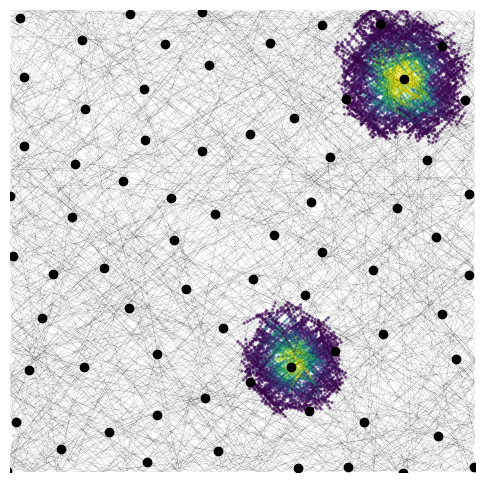

In [178]:
fig = plt.figure(figsize=(6, 6))
plt.plot(*np.array(points[1:]).T, "k-", lw=0.1, alpha=0.5)
#plt.scatter(*np.array(points[1:]).T, c=activity[:, :].sum(axis=0), 
#            s=np.where(activity[:, :].sum(axis=0)>0.01, 2, 0),
#            alpha=0.9, cmap="viridis")

# cell 1 
plt.scatter(*np.array(points[1:]).T, c=activity[12, :]+activity[50, :], 
            s=np.where((activity[12, :]+activity[50, :])>0.01, 2, 0.),
            alpha=0.5, cmap="viridis")

# cell 2
#plt.scatter(*np.array(points[1:]).T, c=activity[50, :], 
#            s=np.where(activity[50, :]>0.01, 2, 0.1),
#            alpha=0.7, cmap="viridis")


plt.scatter(*np.array(centers).T, color="black")
plt.xlim((0, size))
plt.ylim((0, size))
plt.axis("off")

#plt.title("Place cell layer")

plt.show()

In [168]:
centers = brain.get_space_fine_centers()

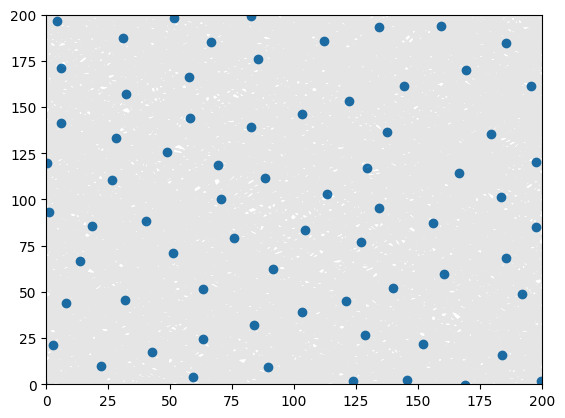

In [169]:
plt.plot(*np.array(points).T, "k-", alpha=0.1)
plt.scatter(*np.array(centers).T)
plt.xlim((0, size))
plt.ylim((0, size))
plt.show()

## Agent 

In [5]:
parameters = utc.load_parameters()

2025-02-27 20:12:31 | 
----
Loading from evolution


0: 1_best_agent.json
1: 2_best_agent.json
2: 3_best_agent.json
3: 4_best_agent.json
4: 5_best_agent.json
5: 6_best_agent.json
6: 7_best_agent.json
7: 8_best_agent.json
8: 9_best_agent.json
9: 10_best_agent.json
10: 11_best_agent.json
11: 12_best_agent.json
12: 13_best_agent.json
13: 14_best_agent.json
14: 15_best_agent.json
15: 16_best_agent.json
16: 17_best_agent.json
17: 18_best_agent.json
18: 19_best_agent.json
19: 20_best_agent.json
20: 21_best_agent.json
21: 22_best_agent.json
22: 23_best_agent.json
23: 24_best_agent.json
24: 25_best_agent.json
25: 26_best_agent.json
26: 27_best_agent.json
27: 28_best_agent.json
28: 29_best_agent.json
29: 30_best_agent.json
30: 31_best_agent.json
31: 32_best_agent.json
32: 33_best_agent.json
33: 34_best_agent.json
34: 35_best_agent.json
35: 36_best_agent.json
36: 37_best_agent.json
37: 38_best_agent.json
38: 39_best_agent.json
39: 40_best_agent.json
40: 41_best_agent.json
41: 42_best_agent.json
42: 43_best_agent.json



>Select file:  41


2025-02-27 20:12:33 | Loaded 42_best_agent.json
2025-02-27 20:12:33 | Agent fitness=108.333


In [27]:
remap_tag_frequency = parameters["remap_tag_frequency"] if "remap_tag_frequency" in parameters else 200
remapping_flag = parameters["remapping_flag"] if "remapping_flag" in parameters else 0
lr_pred = parameters["lr_pred"] if "lr_pred" in parameters else 0.2

brain = pclib.Brain(
            local_scale_fine=global_parameters["local_scale_fine"],
            local_scale_coarse=global_parameters["local_scale_coarse"],
            N=global_parameters["N"],
            Nc=global_parameters["Nc"],
            min_rep_threshold=parameters["min_rep_threshold"],
            num_neighbors=parameters["num_neighbors"],
            rec_threshold_fine=parameters["rec_threshold_fine"],
            rec_threshold_coarse=parameters["rec_threshold_coarse"],
            speed=global_parameters["speed"],
            gain_fine=parameters["gain_fine"],
            offset_fine=parameters["offset_fine"],
            threshold_fine=parameters["threshold_fine"],
            rep_threshold_fine=parameters["rep_threshold_fine"],
            tau_trace_fine=parameters["tau_trace_fine"],
            remap_tag_frequency=remap_tag_frequency,
            gain_coarse=parameters["gain_coarse"],
            offset_coarse=parameters["offset_coarse"],
            threshold_coarse=parameters["threshold_coarse"],
            rep_threshold_coarse=parameters["rep_threshold_coarse"],
            tau_trace_coarse=parameters["tau_trace_coarse"],
            lr_da=parameters["lr_da"],
            lr_pred=lr_pred,
            threshold_da=parameters["threshold_da"],
            tau_v_da=parameters["tau_v_da"],
            lr_bnd=parameters["lr_bnd"],
            threshold_bnd=parameters["threshold_bnd"],
            tau_v_bnd=parameters["tau_v_bnd"],
            tau_ssry=parameters["tau_ssry"],
            threshold_ssry=parameters["threshold_ssry"],
            threshold_circuit=parameters["threshold_circuit"],
            remapping_flag=remapping_flag,
            rwd_weight=parameters["rwd_weight"],
            rwd_sigma=parameters["rwd_sigma"],
            col_weight=parameters["col_weight"],
            col_sigma=parameters["col_sigma"],
            rwd_field_mod_fine=parameters["rwd_field_mod_fine"],
            rwd_field_mod_coarse=parameters["rwd_field_mod_coarse"],
            col_field_mod_fine=parameters["col_field_mod_fine"],
            col_field_mod_coarse=parameters["col_field_mod_coarse"],
            action_delay=50,#parameters["action_delay"], # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
            edge_route_interval=parameters["edge_route_interval"],
            forced_duration=parameters["forced_duration"],
            fine_tuning_min_duration=parameters["fine_tuning_min_duration"],
            min_weight_value=parameters["fine_tuning_min_duration"])

logger(brain)

2025-02-27 20:25:09 | Brain


In [28]:
""" make game environment """

verbose = False
verbose_min = True
game_settings["rendering"] = False
reward_settings["silent_duration"] = 30_000
game_settings["max_duration"] = 40_000

room_name = "Hallway.00"

if verbose and verbose_min:
    logger(f"room_name={room_name}")

room = make_room(name=room_name,
                       thickness=game_settings["room_thickness"],
                       bounds=[0, 1, 0, 1])
room_bounds = [room.bounds[0]+10, room.bounds[2]-10,
               room.bounds[1]+10, room.bounds[3]-10]

# ===| objects |===


possible_positions = room.get_room_positions()

rw_position_idx = np.random.randint(0, len(possible_positions))
rw_position = possible_positions [rw_position_idx]
agent_possible_positions = possible_positions.copy()
agent_position = agent_possible_positions[np.random.randint(0,
                                            len(agent_possible_positions))]
rw_tau = reward_settings["tau"] if "tau" in reward_settings else 400
if "move_threlshold" in reward_settings:
    rw_move_threshold = reward_settings["move_threshold"]
else:
    rw_move_threshold = 2

# --- objects
reward_obj = objects.RewardObj(
            # position=reward_settings["rw_position"],
            position=rw_position,
            possible_positions=possible_positions,
            radius=reward_settings["rw_radius"],
            sigma=reward_settings["rw_sigma"],
            fetching=reward_settings["rw_fetching"],
            value=reward_settings["rw_value"],
            bounds=room_bounds,
            delay=reward_settings["delay"],
            silent_duration=reward_settings["silent_duration"],
            fetching_duration=reward_settings["fetching_duration"],
            use_sprites=global_parameters["use_sprites"],
            tau=rw_tau,
            move_threshold=rw_move_threshold,
            transparent=reward_settings["transparent"])

body = objects.AgentBody(
            position=agent_position,
            speed=global_parameters["speed"],
            possible_positions=agent_possible_positions,
            bounds=game_settings["agent_bounds"],
            use_sprites=global_parameters["use_sprites"],
            room=room,
            color=(10, 10, 10))

logger(reward_obj)

duration = game_settings["max_duration"]

# --- env
env = Environment(room=room,
                        agent=body,
                        reward_obj=reward_obj,
                        duration=game_settings["max_duration"],
                        rw_event=game_settings["rw_event"],
                        verbose=False,
                        visualize=game_settings["rendering"])
logger(env)


""" run game """

# if game_settings["rendering"]:
#     renderer = Renderer(elements=[brain.get_da(), brain.get_bnd()],
#                         space=brain.get_space_fine(),
#                         space_coarse=brain.get_space_coarse(),
#                         brain=brain, colors=["Greens", "Blues"],
#                         names=["DA", "BND"])
# else:
#     renderer = None

if verbose_min:
    logger("[@simulations.py]")
record = sim.run_game(env=env,
         brain=brain,
         renderer=None,
         plot_interval=game_settings["plot_interval"],
         pause=-1,
         record_flag=True,
         verbose=verbose,
         verbose_min=verbose_min)

if verbose_min:
    logger(f"rw_count={env.rw_count}")


2025-02-27 20:25:33 | Reward(300.0, 300.0, silent=30000, probabilistic, transparency=False)
2025-02-27 20:25:33 | Environment(Room(Hallway.00), duration=40000, verbose=False)
2025-02-27 20:25:33 | [@simulations.py]
2025-02-27 20:31:32 | rw_count=144                                                                                   


#### plotting

In [10]:
def get_t(a):
    for t, v in enumerate(a):
        if v > 0.01:
            return t
    return -1

#get_t(activity_fine[:, 4])

In [44]:
activity_fine = np.array(record["activity_fine"])
activity_coarse = np.array(record["activity_coarse"])
trajectory = np.array(record["trajectory"])

bac = np.zeros_like(activity_fine[:, 0])

for i in tqdm(range(0, brain.get_space_fine_size(), 1)):
    if brain.get_bnd_weights()[i] < 0.0001: continue
    st = get_t(activity_fine[:, i])
    bac[st:] += activity_fine[st:, i]

dac = np.zeros_like(activity_fine[:, 0])

for i in tqdm(range(0, brain.get_space_fine_size(), 1)):
    if brain.get_da_weights()[i] < 0.0001: continue
    st = get_t(activity_fine[:, i])
    dac[st:] += activity_fine[st:, i]

100%|████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:00<00:00, 29031.95it/s]


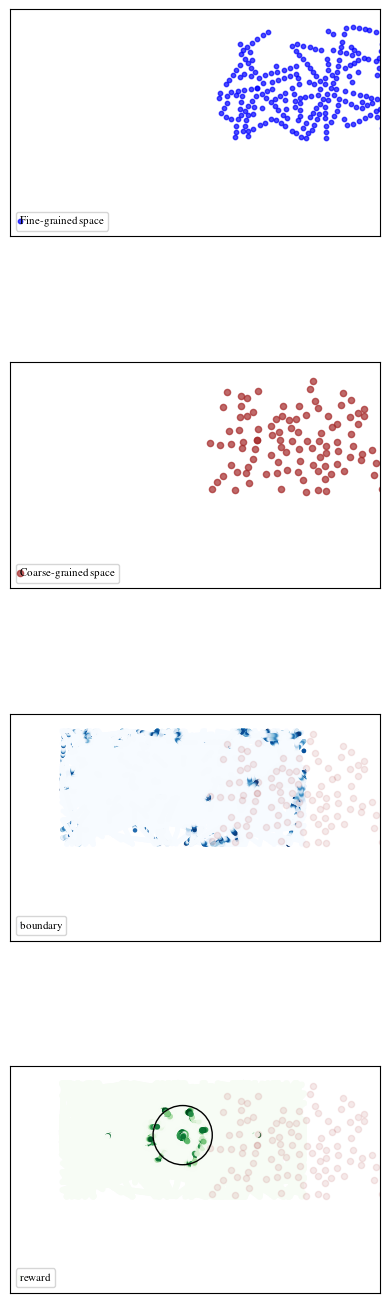

In [30]:
fig, axs = plt.subplots(4, 1, figsize=(4, 15))
fig.set_tight_layout({"h_pad": -0})
boundsx = (-500, 250)
boundsy = (-300, 160)
off_bnd = [450, 280]
off_da = [450, 280]

axs = axs.flatten()

# -- space plots --
axs[0].clear()
axs[1].clear()


# -- fine space
axs[0].scatter(*np.array(brain.get_space_fine_centers()).T,
                       color="blue", s=10, alpha=0.7,
              label="Fine-grained space")

# -- fine space
# axs[0, 0].set_title(f"#PCs={brain.get_space_fine_count()}")
#axs[0].set_title(f"Fine-grained space")

axs[0].set_xlim(boundsx)
axs[0].set_ylim(boundsy)
axs[0].set_aspect('equal', adjustable='box')
axs[0].grid(alpha=0.1)
axs[0].legend(loc="lower left", handlelength=0, handletextpad=0)

axs[0].set_xticks(())
axs[0].set_yticks(())

# -- coarse space
# axs[0, 1].set_title(f"#PCs={brain.get_space_coarse_count()}")

#for edge in brain.make_space_coarse_edges():
#    axs[1].plot((edge[0][0], edge[1][0]), (edge[0][1], edge[1][1]),
#                    alpha=0.1, lw=0.5, color="black")

axs[1].scatter(*np.array(brain.get_space_coarse_centers()).T,
                       color="brown", s=20, alpha=0.7,
              label="Coarse-grained space")

axs[1].set_xlim(boundsx)
axs[1].set_ylim(boundsy)
axs[1].set_xticks(())
axs[1].set_yticks(())
axs[1].set_aspect('equal', adjustable='box')
axs[1].grid(alpha=0.1)
axs[1].legend(loc="lower left", handlelength=0, handletextpad=0)


# -- BND
axs[2].clear()
axs[2].scatter(*trajectory.T-np.array(off_bnd).reshape(-1, 1),
                  c=bac, cmap="Blues", s=np.where(dac>-10, 5, 0),
               alpha=0.9, vmin=0, vmax=0.5,
              label="boundary")
axs[2].scatter(*np.array(brain.get_space_coarse_centers()).T,
                       color="brown", s=20, alpha=0.1)

axs[2].scatter(*np.array(brain.get_space_fine_centers()).T,
                       c=brain.get_bnd_weights(),
                       cmap="Blues", alpha=0.,
                       s=10, vmin=0., vmax=0.2)
axs[2].scatter(*np.array(brain.get_space_coarse_centers()).T,
                       color="brown", s=20, alpha=0.)
axs[2].set_xlim(boundsx)
axs[2].set_ylim(boundsy)
axs[2].set_xticks(())
axs[2].set_yticks(())
#axs[2].set_title(f"BND")
axs[2].set_aspect('equal', adjustable='box')
axs[2].legend(loc="lower left", handlelength=0, handletextpad=0)


# -- DA
axs[3].clear()
axs[3].scatter(*trajectory.T-np.array(off_da).reshape(-1, 1),
                  c=dac, cmap="Greens", 
               s=np.where(dac>-10, 10, 0), alpha=0.9, 
               vmin=0, vmax=0.5,
              label="reward")
axs[3].scatter(*np.array(brain.get_space_coarse_centers()).T,
                       color="brown", s=20, alpha=0.1)

daw = brain.get_da_weights()
axs[3].scatter(*np.array(brain.get_space_fine_centers()).T,
                       c=daw,
                       s=np.where(daw > 0.01, 20, 1),
                       cmap="Greens", alpha=0.,
                       vmin=0., vmax=0.2)
circle = Circle(reward_obj.position-np.array(off_da),
                reward_obj.radius, edgecolor='black', facecolor='none')
axs[3].add_patch(circle)

axs[3].set_xlim(boundsx)
axs[3].set_ylim(boundsy)
axs[3].set_xticks(())
axs[3].set_yticks(())
#axs[3].set_title(f"DA")
axs[3].legend(loc="lower left", handlelength=0, handletextpad=0)
axs[3].set_aspect('equal', adjustable='box')

plt.show()


In [31]:
activity_fine = np.array(record["activity_fine"])
activity_coarse = np.array(record["activity_coarse"])
trajectory = np.array(record["trajectory"])

bac = np.zeros_like(activity_fine[:, 0])

for i in tqdm(range(0, brain.get_space_fine_size(), 1)):
    if brain.get_bnd_weights()[i] < 0.0001: continue
    st = get_t(activity_fine[:, i])
    bac[st:] += activity_fine[st:, i]

dac = np.zeros_like(activity_fine[:, 0])

for i in tqdm(range(0, brain.get_space_fine_size(), 1)):
    if brain.get_da_weights()[i] < 0.0001: continue
    st = get_t(activity_fine[:, i])
    dac[st:] += activity_fine[st:, i]

100%|████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:00<00:00, 25069.24it/s]


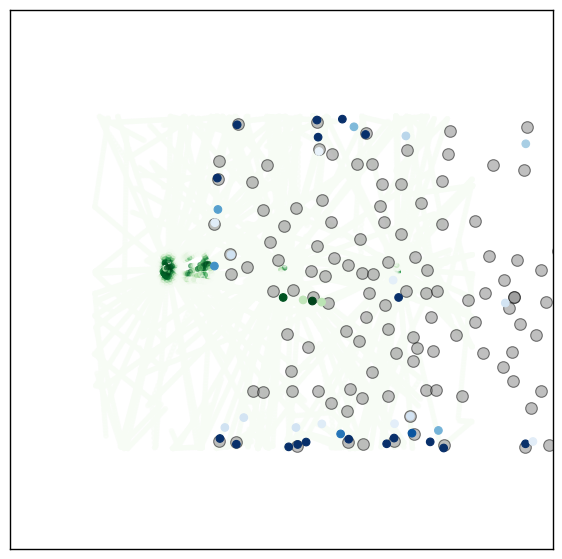

In [135]:
fig = plt.figure(figsize=(7, 7))

cc = np.array(brain.get_space_fine_centers()).T

bx = (-355, 350)
by = (-175, 200)

#plt.scatter(*cc, s=30, alpha=0.2, edgecolor="black", facecolor="white")
#plt.scatter(*trajectory.T-np.array([[300], [280]]), c=ac, cmap="Reds", s=np.where(ac>-10, 10, 0), alpha=.2, vmin=0, vmax=0.5)
plt.scatter(*trajectory.T-np.array([[300], [280]]), c=dac, cmap="Greens", s=np.where(dac>-10, 10, 0), alpha=0.5, vmin=0, vmax=0.5)


plt.scatter(*np.array(brain.get_space_coarse_centers()).T, s=70, alpha=0.5, edgecolor="black", facecolor="grey")


plt.scatter(*cc, c=brain.get_bnd_weights(), s=np.where(brain.get_bnd_weights()>0.001, 30, 0),
            cmap="Blues", vmin=0., vmax=0.3)

plt.scatter(*cc, c=brain.get_da_weights(), s=np.where(brain.get_da_weights()>0.001, 30, 0),
            cmap="Greens", vmin=0., vmax=0.9)
#plt.title("Neuromodulation", fontsize=37, y=1.02)
plt.xticks(())
plt.yticks(())
plt.xlim(bx)
plt.ylim(by)

plt.show()

In [40]:
trajectory[:, :2]

array([[300.        , 300.        ],
       [300.        , 300.        ],
       [300.        , 300.        ],
       ...,
       [417.69148767, 287.61060514],
       [414.90359247, 287.7166499 ],
       [416.5207032 , 288.89349009]])

In [32]:
activity_fine = np.array(record["activity_fine"])
activity_coarse = np.array(record["activity_coarse"])
trajectory = np.array(record["trajectory"])

In [7]:
trajectory.shape

(9999, 2)

In [21]:
def get_t(a):
    for t, v in enumerate(a):
        if v > 0.01:
            return t
    return -1

get_t(activity_fine[:, 4])

119

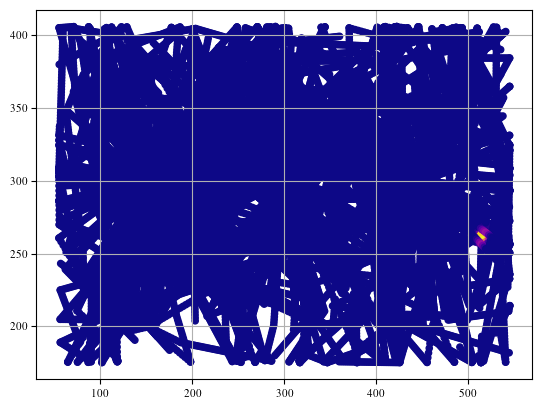

In [33]:
i = 50
st = get_t(activity_fine[:, i])
plt.scatter(*trajectory[st:].T, c=activity_fine[st:, i], cmap="plasma", s=np.where(activity_fine[st:, i]>-90.0, 20, 0))
#plt.ylim((200, 350))
#plt.xlim((50, 550))
plt.grid()
plt.show()

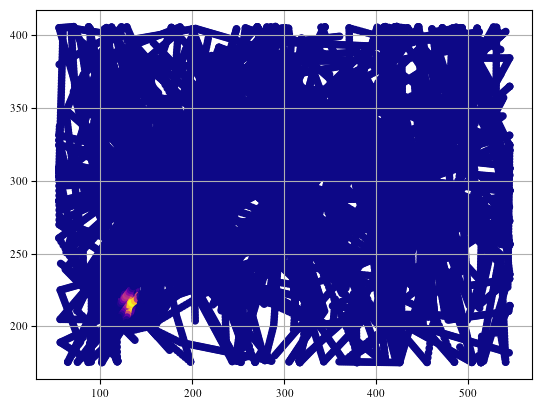

In [34]:
i = 34
st = get_t(activity_coarse[:, i])
plt.scatter(*trajectory[st:].T, c=activity_coarse[st:, i], cmap="plasma", s=np.where(activity_coarse[st:, i]>-90.0, 20, 0))
#plt.ylim((200, 350))
#plt.xlim((50, 550))
plt.grid()
plt.show()

In [77]:
ac = np.zeros_like(activity_fine[:, 0])
ac1 = np.zeros_like(activity_fine[:, 0])

for i in tqdm(range(0, brain.get_space_fine_size(), 1)):
    st = get_t(activity_fine[:, i])
    ac[st:] += activity_fine[st:, i] * brain.get_bnd_weights()[i]
    ac1[st:] += activity_fine[st:, i] * (1-brain.get_bnd_weights()[i]>0.5)

100%|█████████████████████████████████████████████████████| 625/625 [00:08<00:00, 70.46it/s]


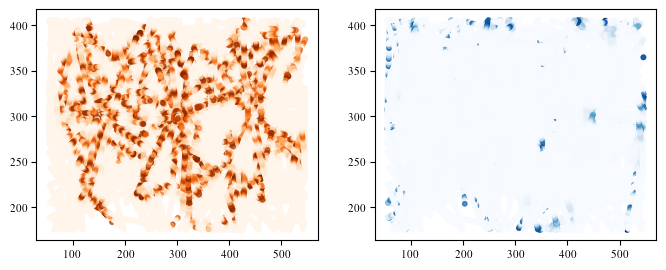

In [84]:
plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.scatter(*trajectory.T, c=ac1, cmap="Oranges", 
            s=np.where(ac1>-10, 10, 0), alpha=.7, vmin=0, vmax=0.5)
plt.subplot(122)
plt.scatter(*trajectory.T, c=ac, cmap="Blues", 
            s=np.where(ac>-10, 10, 0), alpha=.7, vmin=0, vmax=0.5)
plt.show()

In [40]:
acc = np.zeros_like(activity_coarse[:, 0])

for i in tqdm(range(0, brain.get_space_coarse_size(), 1)):
    st = get_t(activity_coarse[:, i])
    acc[st:] += activity_coarse[st:, i]

100%|███████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:04<00:00, 56.07it/s]


In [38]:
brain.get_space_coarse_count()

174

In [48]:
activity_coarse.shape

(39999, 256)

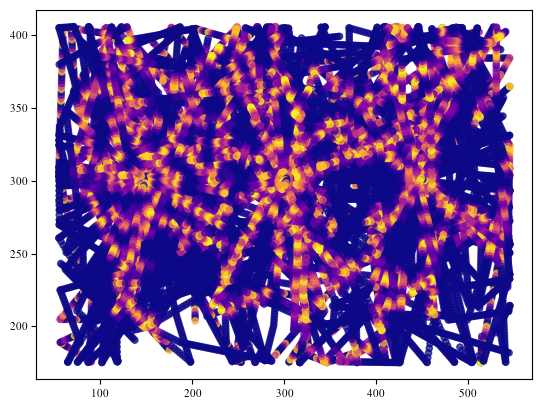

In [39]:
plt.scatter(*trajectory.T, c=ac, cmap="plasma", s=np.where(ac>-10, 20, 0), alpha=.7, vmin=0, vmax=0.5)
#plt.ylim((200, 350))
#plt.xlim((50, 550))
plt.show()

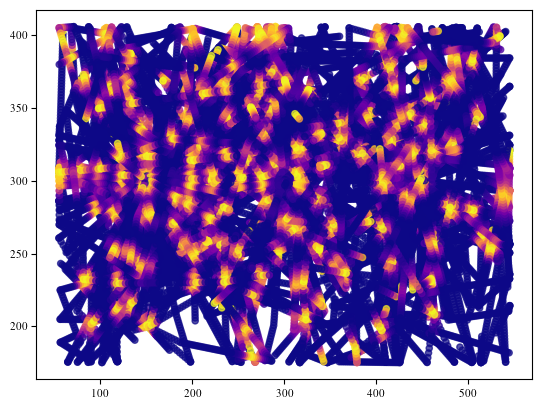

In [47]:
plt.scatter(*trajectory.T, c=acc, cmap="plasma", s=np.where(acc>-10, 20, 0), alpha=.7, vmin=0, vmax=0.5)
#plt.ylim((200, 350))
#plt.xlim((50, 550))
plt.show()

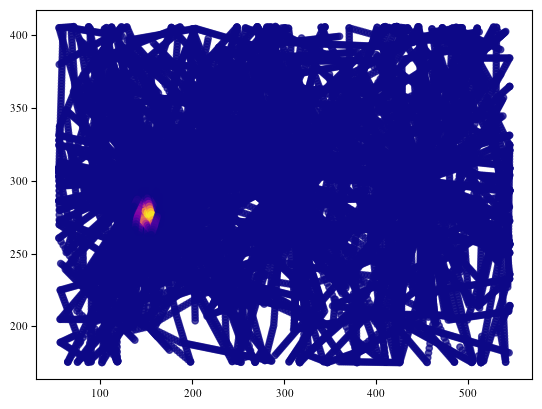

In [54]:
i = 30
plt.scatter(*trajectory.T, c=activity_coarse[:, i], cmap="plasma",
            s=np.where(activity_coarse[:, i]>-10, 20, 0), alpha=.7, vmin=0, vmax=0.5)
#plt.ylim((200, 350))
#plt.xlim((50, 550))
plt.show()

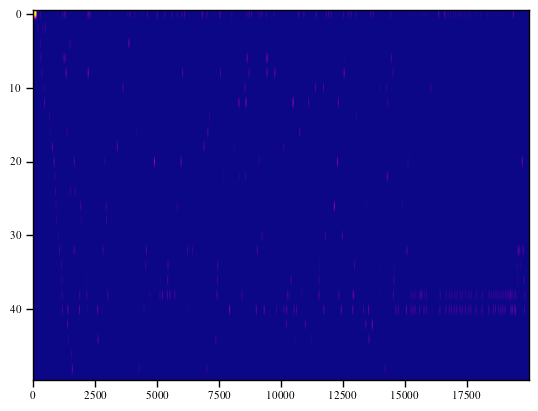

In [143]:
plt.imshow(activity_coarse.T[:50], cmap="plasma", aspect="auto");

#### pc fields

In [80]:
remap_tag_frequency = parameters["remap_tag_frequency"] if "remap_tag_frequency" in parameters else 200
remapping_flag = parameters["remapping_flag"] if "remapping_flag" in parameters else 0
lr_pred = parameters["lr_pred"] if "lr_pred" in parameters else 0.2

brain = pclib.Brain(
            local_scale_fine=global_parameters["local_scale_fine"],
            local_scale_coarse=global_parameters["local_scale_coarse"],
            N=global_parameters["N"],
            Nc=global_parameters["Nc"],
            min_rep_threshold=parameters["min_rep_threshold"],
            num_neighbors=parameters["num_neighbors"],
            rec_threshold_fine=parameters["rec_threshold_fine"],
            rec_threshold_coarse=parameters["rec_threshold_coarse"],
            speed=global_parameters["speed"],
            gain_fine=parameters["gain_fine"],
            offset_fine=parameters["offset_fine"],
            threshold_fine=parameters["threshold_fine"],
            rep_threshold_fine=parameters["rep_threshold_fine"],
            tau_trace_fine=parameters["tau_trace_fine"],
            remap_tag_frequency=remap_tag_frequency,
            gain_coarse=parameters["gain_coarse"],
            offset_coarse=parameters["offset_coarse"],
            threshold_coarse=parameters["threshold_coarse"],
            rep_threshold_coarse=parameters["rep_threshold_coarse"],
            tau_trace_coarse=parameters["tau_trace_coarse"],
            lr_da=parameters["lr_da"],
            lr_pred=lr_pred,
            threshold_da=parameters["threshold_da"],
            tau_v_da=parameters["tau_v_da"],
            lr_bnd=parameters["lr_bnd"],
            threshold_bnd=parameters["threshold_bnd"],
            tau_v_bnd=parameters["tau_v_bnd"],
            tau_ssry=parameters["tau_ssry"],
            threshold_ssry=parameters["threshold_ssry"],
            threshold_circuit=parameters["threshold_circuit"],
            remapping_flag=remapping_flag,
            rwd_weight=parameters["rwd_weight"],
            rwd_sigma=parameters["rwd_sigma"],
            col_weight=parameters["col_weight"],
            col_sigma=parameters["col_sigma"],
            rwd_field_mod_fine=parameters["rwd_field_mod_fine"],
            rwd_field_mod_coarse=parameters["rwd_field_mod_coarse"],
            col_field_mod_fine=parameters["col_field_mod_fine"],
            col_field_mod_coarse=parameters["col_field_mod_coarse"],
            action_delay=parameters["action_delay"],
            edge_route_interval=parameters["edge_route_interval"],
            forced_duration=parameters["forced_duration"],
            fine_tuning_min_duration=parameters["fine_tuning_min_duration"],
            min_weight_value=parameters["fine_tuning_min_duration"])

logger(brain)

2025-02-27 13:48:52 | Brain


In [81]:
N = brain.get_space_fine_size()

# random walk
speed = 1
size = 100.
sizey = 100

points = [[0., 0.]]

s = np.array([speed, speed])
x, y = points[0]
old_point = points[0]

tot = 10_000

# record
activity = np.zeros((N, tot))
plotting = 0

for t in tqdm(range(tot)):
    
    x += s[0]
    y += s[1]

    # hit wall
    if x <= 0 or x >= size:
        s[0] *= -1
        x += s[0]
    elif y <= 0 or y >= sizey:
        s[1] *= -1
        y += s[1]

    points += [[x, y]]
    if t % 500 == 0:
        s = np.random.uniform(-1, 1, 2)
        s = speed * s / np.abs(s).sum()
        s = np.around(s, 3)

    activity[:, t] = brain([points[-1][0]-old_point[0],
                            points[-1][1]-old_point[1]], 0., 0., False)[0]
    
    old_point = points[-1]

    if t % 100 == 0 and plotting:
        clear_output(wait=True)
        plt.figure(figsize=(4, 4))
        #plt.subplot(121)
        plt.plot(*np.array(points).T, 'k-', lw=0.3, alpha=0.3)
        
        #plt.scatter(*np.array(gc.get_positions()).T, s=50, color="blue")

        plt.title(f"{t=}")
        #plt.subplot(122)
        #plt.imshow(activity[:, t-500:t], cmap="plasma", aspect="auto")
        #plt.plot(range(len(activity)), len(activity) - activity*10, '-', color="white", lw=2)
        #plt.axis('off')
        
        plt.scatter(*points[-1], s=100, c='r')

        plt.xlim((-4, size+4))
        plt.ylim((-4, size+4))
        plt.pause(0.001)

logger()

100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 969.47it/s]
2025-02-27 13:49:05 | 


In [9]:
np.clip(activity[40, -100:], 0, 10)
plt.imshow(np.clip(activity, 0, 10), cmap="plasma")
plt.show()

NameError: name 'activity' is not defined

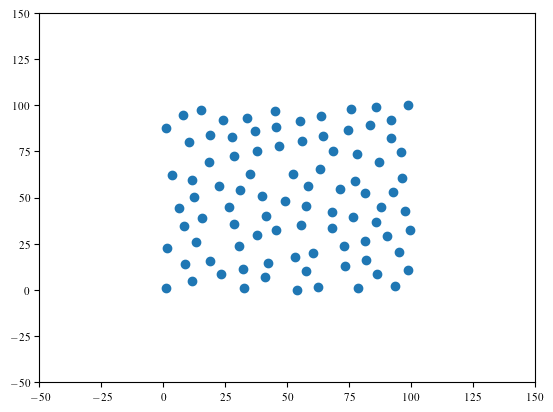

In [90]:
plt.scatter(*np.array(brain.get_space_fine_centers()).T)
plt.xlim((-50, 150))
plt.ylim((-50, 150))
plt.show()

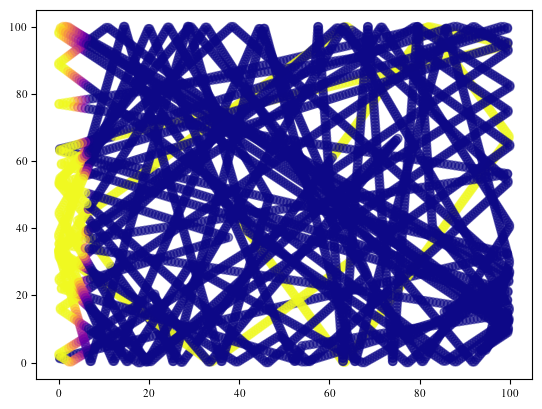

In [91]:
#asum = activity[:, :].mean(axis=0)
asum = np.clip(activity[40, :], 0, 10)
plt.scatter(*np.array(points[1:]).T, c=asum, alpha=0.5, cmap="plasma", vmin=0., vmax=0.4);


In [16]:
renderer.render()
plt.show()

In [79]:
brain.get_space_fine_count()

541

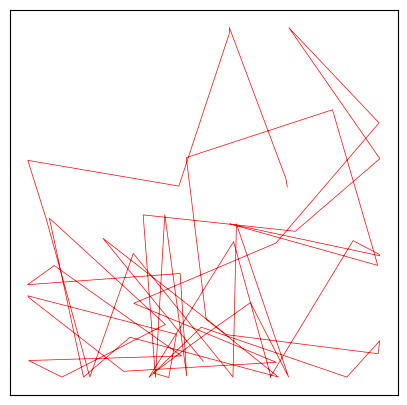

In [228]:
plt.figure(figsize=(5, 5))
for tr in env.trajectory_set:
    plt.plot(*np.array(tr).T, 'r-', lw=0.5)

plt.xticks(())
plt.yticks(())
plt.show()

## performance study

In [108]:
path = "analysis/results"
files = {i: f for i, f in enumerate(os.listdir(path)) if "performance_252_23" in f}

print(f"{files}")
ans = input("idx: ")
ans = int(ans) if ans != "" else list(files.keys())[0]
rpath = path + "/" + files[ans]
with open(rpath + "/metadata.json", "r") as fr:
    metadata = json.load(fr)
with open(rpath + "/data.json", "r") as fr:
    data = json.load(fr)

print("-"*50)
print(f"room={metadata['room']}")
print(f"result={np.mean(data):.1f}+-{np.std(data):.2f}")

{18: 'performance_252_2325', 20: 'performance_252_2313'}


idx:  18


--------------------------------------------------
room=Flat.1011
result=89.9+-36.56


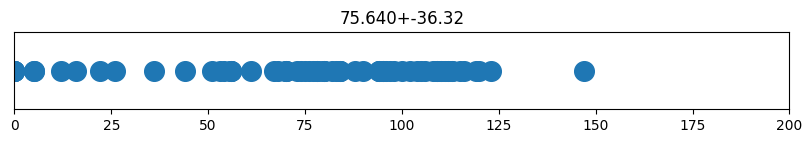

In [106]:
plt.figure(figsize=(10, 1))
plt.scatter(data, [0]*len(data), s=200)
plt.yticks(())
plt.xlim((0, 200))
plt.title(f"{np.mean(data):.3f}+-{np.std(data):.2f}")
plt.show()

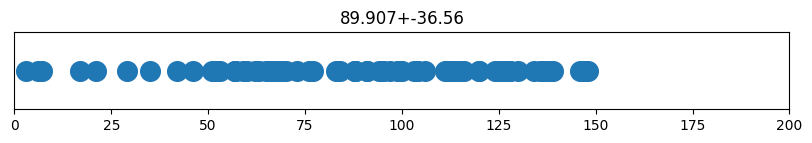

In [109]:
plt.figure(figsize=(10, 1))
plt.scatter(data, [0]*len(data), s=200)
plt.yticks(())
plt.xlim((0, 200))
plt.title(f"{np.mean(data):.3f}+-{np.std(data):.2f}")
plt.show()

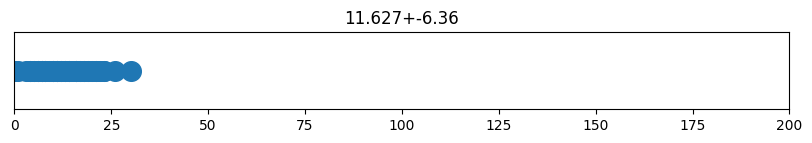

In [92]:
plt.figure(figsize=(10, 1))
plt.scatter(data, [0]*len(data), s=200)
plt.yticks(())
plt.xlim((0, 200))
plt.title(f"{np.mean(data):.3f}+-{np.std(data):.2f}")
plt.show()

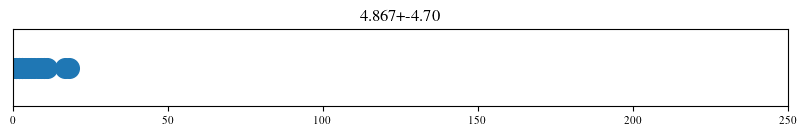

In [214]:
plt.figure(figsize=(10, 1))
plt.scatter(data, [0]*len(data), s=200)
plt.yticks(())
plt.xlim((0, 250))
plt.title(f"{np.mean(data):.3f}+-{np.std(data):.2f}")
plt.show()

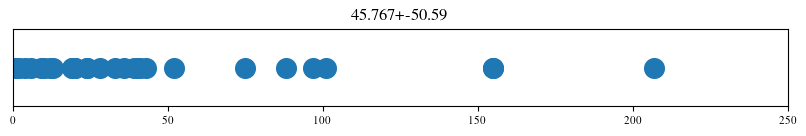

In [210]:
plt.figure(figsize=(10, 1))
plt.scatter(data, [0]*len(data), s=200)
plt.yticks(())
plt.xlim((0, 250))
plt.title(f"{np.mean(data):.3f}+-{np.std(data):.2f}")
plt.show()

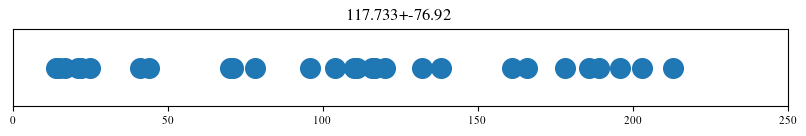

In [205]:
plt.figure(figsize=(10, 1))
plt.scatter(data, [0]*len(data), s=200)
plt.yticks(())
plt.xlim((0, 250))
plt.title(f"{np.mean(data):.3f}+-{np.std(data):.2f}")
plt.show()

In [146]:
print(f"result={np.mean(data):.1f}+-{np.std(data):.2f}")

result=15.4+-15.60


## evolution study

In [21]:
evopath = os.getcwd() + "/cache/"
evolist = {i: f for i, f in enumerate(os.listdir(evopath)) if int(f.split("_")[0]) > 40}
logger(evolist)
with open(evopath + evolist[int(input("\nidx: "))], 'r') as f:
    evorun = json.load(f)

logger(evorun['info']['date'])
logger(evorun['info']['evolution'])

2025-02-27 18:44:16 | {18: '41_best_agent.json', 31: '42_best_agent.json'}



idx:  31


2025-02-27 18:44:18 | 26/02/2025 at 20:32
2025-02-27 18:44:18 | {'NPOP': 256, 'NGEN': 200, 'CXPB': 0.6, 'MUTPB': 0.7, 'NLOG': 1, 'TARGET': [1.0], 'TARGET_ERROR': 0.0, 'NUM_CORES': 256, 'USE_TQDM': False}


In [25]:
evorun['info'].keys()

dict_keys(['date', 'model', 'game', 'evolution', 'evolved', 'data', 'other', 'performance', 'fitness_record', 'record_genome'])

In [45]:
evorun['info']['record_genome']['0'].keys()

dict_keys(['genome', 'fitness'])

In [52]:
def make_evo_params_dict(run) -> dict:

    names = run['info']['evolved']
    data = {name: [] for name in names}
    data['fitness'] = []
    for _, ind in run['info']['record_genome'].items():
        data['fitness'] += [ind['fitness']]
        for name in names:
            data[name] += [ind['genome'][name]]

    return data, names

In [53]:
evoparams, evonames = make_evo_params_dict(evorun)

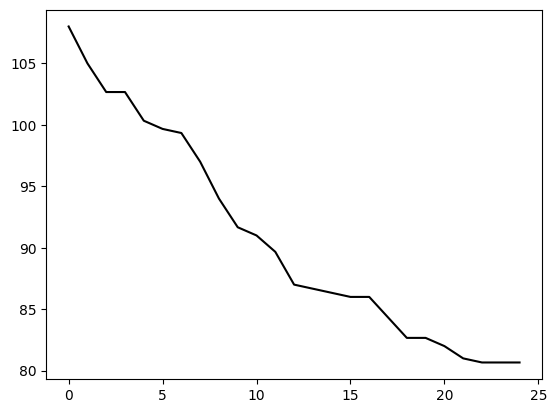

In [63]:
plt.plot(range(len(evoparams['fitness'])), evoparams['fitness'], 'k-');

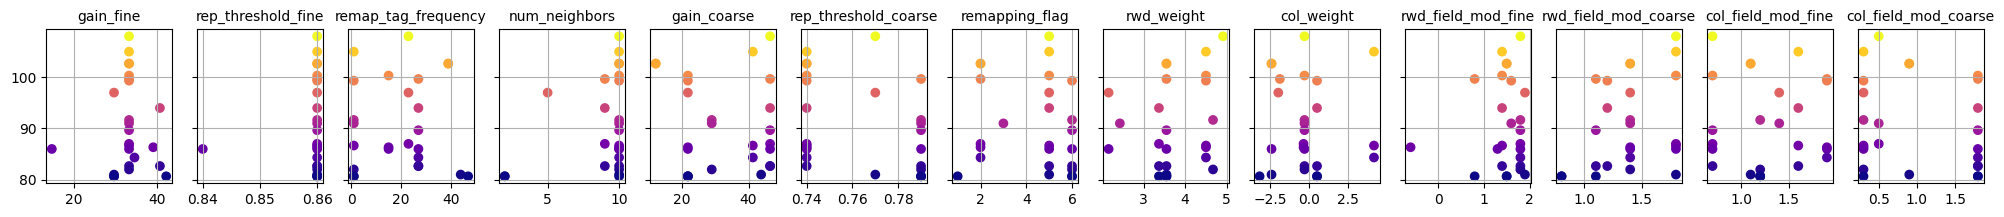

In [71]:
fig, axs = plt.subplots(1, len(evonames), figsize=(25, 2), sharey=True)

for i, ax in enumerate(axs):

    ax.scatter(evoparams[evonames[i]], evoparams['fitness'], c=evoparams['fitness'], cmap='plasma')
    ax.grid()
    #ax.axis("equal")
    ax.set_title(evonames[i], fontsize=10)

plt.show()

## performance plot

In [108]:
runpath = os.getcwd() + "/analysis/results/"
runlist = {i: f for i, f in enumerate(os.listdir(runpath)) if f.startswith("option")}
logger(runlist)
runidx = input("idx: ")
runidx = tuple(runlist.keys())[-1] if runidx == "" else runidx
with open(runpath + runlist[int(runidx)], 'r') as f:
    run = json.load(f)


2025-02-27 19:51:16 | {13: 'options_eval_272_1845.json', 20: 'options_eval_272_1938.json', 27: 'options_eval_272_1919.json'}


idx:  27


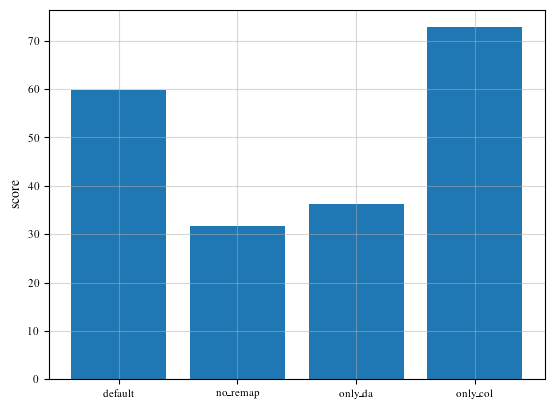

In [111]:
#plt.style.use('science')  # Requires matplotlib-style package
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times', 'Computer Modern Roman'],
    'text.usetex': True,
    'axes.labelsize': 10,
    'font.size': 10,
    'legend.fontsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8
})

data = np.array(run['results'])

plt.bar(range(4), data.mean(axis=0))
plt.xticks(range(4), run['options'])
plt.grid(alpha=0.5)
plt.ylabel("score")
plt.show()

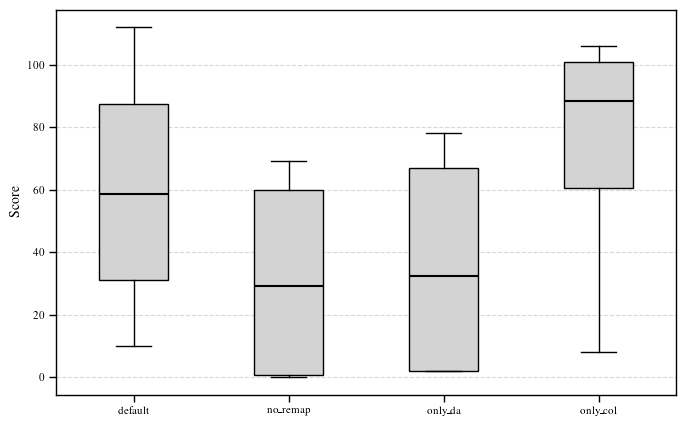

In [119]:
data = np.array(run['results'])  # Assuming shape (N, 4) where N is number of runs

# Create box plot
plt.figure(figsize=(8, 5))  # Adjust figure size
plt.boxplot(data, patch_artist=True, 
            boxprops=dict(facecolor="lightgray", color="black"),
            medianprops=dict(color="black", linewidth=1.5),
            whiskerprops=dict(color="black", linewidth=1),
            capprops=dict(color="black", linewidth=1))

plt.xticks(range(1, 5), run['options'])  # Boxplot indexes from 1
plt.ylabel("Score")
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.show()